# Fraud Detection Using Neural Network - A Supervised Deep Learning Method

## Introduction
In this lab, we are going to use the Neural Network to perform fraud detection. We are going to use the same dataset i.e. credit card data set. 

From previous labs we know that our dataset is highly imbalanced. The class column corresponds to whether or not a transaction is fradulent. We see that the majority of data is non-fraudulant with only $492$ ($.173\%$) of the data corresponding to fraudulant examples.

For unbalanced data sets like ours where the positive (fraudulent) examples occur much less frequently than the negative (legitimate) examples, we may try “over-sampling” the minority dataset by generating synthetic data (read about SMOTE in Data Mining for Imbalanced Datasets: An Overview (https://link.springer.com/chapter/10.1007%2F0-387-25465-X_40) or undersampling the majority class by using ensemble methods (see http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.68.6858&rep=rep1&type=pdfor).

Let's start by installing one of the liabraries for SMOTE technique.

In [1]:
!pip install -U imbalanced-learn

     |████████████████████████████████| 163kB 31.7MB/s eta 0:00:01
     |████████████████████████████████| 7.1MB 46.6MB/s eta 0:00:01
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3
You should consider upgrading via the 'pip install --upgrade pip' command.


In [8]:
# creating directory structure
!mkdir ../data
!mkdir ../model
!mkdir ../logs

In [5]:
# first neural network with keras tutorial
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN
from sagemaker.tensorflow import TensorFlow
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


## Downloading data

In [9]:
!curl https://s3-us-west-2.amazonaws.com/sagemaker-e2e-solutions/fraud-detection/creditcardfraud.zip -o ../data/creditcardfraud.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.9M  100 65.9M    0     0  10.6M      0  0:00:06  0:00:06 --:--:-- 12.6M


In [10]:
!unzip -o ../data/creditcardfraud.zip -d ../data/

Archive:  ../data/creditcardfraud.zip
  inflating: ../data/creditcard.csv  


## Load and Visualize

In [11]:
data = pd.read_csv('../data/creditcard.csv', delimiter=',')

In [12]:
data.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


Text(0, 0.5, 'Frequency')

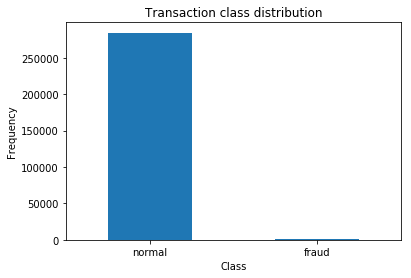

In [13]:
labels = ['normal','fraud']
classes = pd.value_counts(data['Class'], sort = True)
classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

As we learned in previous labs, that features like 'Time', and 'Amount' are not that relevant. So let's drop these fields.

In [14]:
data = data.drop(['Time','Amount'],axis=1)

## Split dateset into Train, Validation, and Test

In [15]:
import boto3
import os
import sagemaker
from sklearn.model_selection import train_test_split

session = sagemaker.Session()

bucket = session.default_bucket()
sagemaker_iam_role = sagemaker.get_execution_role()

prefix = 'sagemaker/NeuralNetwork-fraud'

RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

train_data, test_data = train_test_split(data, test_size=TEST_PCT,random_state=RANDOM_SEED)
validation_data, test_data = train_test_split(test_data, test_size=0.5,random_state=RANDOM_SEED)

## Balacing our Training dataset

In [17]:
X = train_data.iloc[:, 0:28]
y = train_data.iloc[:,28:29]
print(X.shape)
print(y.shape)

X_resampled, y_resampled = SMOTE().fit_resample(X, y)

X = X_resampled
y = y_resampled

print(X.shape)
print(y.shape)
train_data = np.concatenate((X, y),axis=1)
train_data = pd.DataFrame(train_data)
train_data.shape

(227845, 28)
(227845, 1)
(454936, 28)
(454936, 1)


(454936, 29)

In [18]:
X_resampled.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,0.260538,0.644354,-0.649921,-0.053463,0.883230,-0.757973,0.787879,-0.142056,0.291431,-0.926765,...,0.479066,-0.126591,0.124600,0.572313,-0.245022,-0.698144,-0.375306,0.715218,0.081376,0.108298
1,-1.382266,0.112162,0.541746,1.459137,-1.320120,0.881505,1.274878,0.692477,-0.523981,-0.419198,...,0.934510,0.683867,0.246174,0.160448,0.774357,-0.064849,-0.023380,-0.242420,0.158846,0.153550
2,1.998524,-0.228993,-0.276857,0.572004,-0.305767,0.025961,-0.706267,-0.068867,2.603357,-0.577862,...,-0.453597,-0.184725,0.043219,0.657304,0.150440,0.592132,-0.064754,-0.277614,0.020307,-0.036267
3,0.736055,-0.423105,0.280255,1.521043,-0.739431,-0.982784,0.463617,-0.284605,-0.061795,-0.048532,...,-0.676679,0.346534,0.240533,0.182956,-0.285509,0.727483,0.538996,-0.326837,-0.027806,0.068051
4,2.063104,-0.064287,-0.955170,0.639229,-0.229669,-1.213497,-0.025961,-0.317086,2.089984,-0.246140,...,-0.048739,-0.379353,-0.459128,-1.026646,0.373861,-0.062467,-0.381783,0.162610,-0.108893,-0.069974


In [19]:
y_resampled.head()

,Class
0,0
1,0
2,0
3,0
4,0


In [20]:
train_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.260538,0.644354,-0.649921,-0.053463,0.883230,-0.757973,0.787879,-0.142056,0.291431,-0.926765,...,-0.126591,0.124600,0.572313,-0.245022,-0.698144,-0.375306,0.715218,0.081376,0.108298,0.0
1,-1.382266,0.112162,0.541746,1.459137,-1.320120,0.881505,1.274878,0.692477,-0.523981,-0.419198,...,0.683867,0.246174,0.160448,0.774357,-0.064849,-0.023380,-0.242420,0.158846,0.153550,0.0
2,1.998524,-0.228993,-0.276857,0.572004,-0.305767,0.025961,-0.706267,-0.068867,2.603357,-0.577862,...,-0.184725,0.043219,0.657304,0.150440,0.592132,-0.064754,-0.277614,0.020307,-0.036267,0.0
3,0.736055,-0.423105,0.280255,1.521043,-0.739431,-0.982784,0.463617,-0.284605,-0.061795,-0.048532,...,0.346534,0.240533,0.182956,-0.285509,0.727483,0.538996,-0.326837,-0.027806,0.068051,0.0
4,2.063104,-0.064287,-0.955170,0.639229,-0.229669,-1.213497,-0.025961,-0.317086,2.089984,-0.246140,...,-0.379353,-0.459128,-1.026646,0.373861,-0.062467,-0.381783,0.162610,-0.108893,-0.069974,0.0
5,1.938746,-1.348070,-0.571826,-0.898448,-1.164698,-0.275187,-0.997756,0.074171,-0.038386,0.851980,...,0.126071,0.041904,-0.151810,0.264565,-0.440844,-0.564571,-0.486713,-0.012370,-0.038735,0.0
6,-0.766821,1.168886,0.951680,0.717384,1.039082,-0.346663,1.765473,-0.569001,-0.578734,0.621377,...,0.109518,-0.040673,0.372062,-0.705867,0.010709,1.003730,-0.266130,-0.277632,-0.368166,0.0
7,1.295694,0.400421,0.098359,0.558956,-0.036970,-0.746547,0.129645,-0.215352,-0.053382,-0.305466,...,-0.012401,-0.313920,-0.862230,0.053621,-0.170914,0.315438,0.125078,-0.018383,0.027028,0.0
8,1.246454,0.038172,-0.059950,-0.096151,-0.195872,-0.812450,0.183660,-0.112738,-0.199824,0.046081,...,-0.061652,-0.411634,-1.348499,0.148395,-0.000230,0.084480,0.625746,-0.113259,-0.008212,0.0
9,2.016774,0.007711,-3.298051,0.125037,3.076508,3.037594,0.199125,0.576568,-0.306699,0.383016,...,-0.166750,0.131568,0.328318,0.007529,0.701816,0.502323,-0.465696,-0.016936,-0.066347,0.0


Text(0, 0.5, 'Frequency')

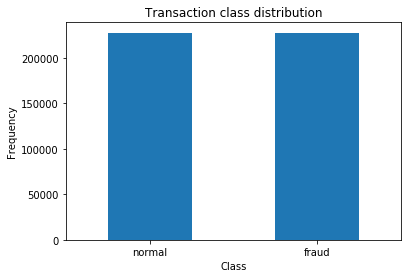

In [21]:
labels = ['normal','fraud']
classes = pd.value_counts(train_data.iloc[:,28], sort = True)
classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

After balancing the dataset between fraud and non-fraud, we have equal number of records for both the categories in our training set.

## Uploading our dataset to S3

In [22]:
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)
test_data.to_csv('test.csv', header=False, index=False)


boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')) \
                                .upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')) \
                                .upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')) \
                                .upload_file('test.csv')

s3_train_data = 's3://{}/{}/train/train.csv'.format(bucket, prefix)
s3_validation_data = 's3://{}/{}/validation/validation.csv'.format(bucket, prefix)


output_location = 's3://{}/{}/output'.format(bucket, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://sagemaker-us-east-1-232367251376/sagemaker/NeuralNetwork-fraud/output


## Set Up and Launch Training

In [23]:
role = sagemaker.get_execution_role()

In [24]:
epochs = 50
batchsize = 1000
key = "data"
key_output = "output"                   # Path from the bucket's root to the dataset
train_instance_type='ml.m4.xlarge'      # The type of EC2 instance which will be used for training
deploy_instance_type='ml.m4.xlarge'     # The type of EC2 instance which will be used for deployment
hyperparameters={
    "learning_rate": 1e-4,
    "decay": 1e-6,
    "epochs": epochs, 
    "batch_size": batchsize
}

In [25]:
inputs = {'training': s3_train_data, 'validation': s3_validation_data}

In [26]:
model_dir = '/opt/ml/model'

In [27]:
my_estimator = TensorFlow(entry_point='train_nn.py',
                               role=role,
                               model_dir=model_dir,
                               framework_version='1.13',                                  
                               train_instance_count=1,
                               train_instance_type=train_instance_type,
                               #train_instance_type='local',
                               py_version='py3',
                               script_mode=True,
                               base_job_name='Neural-Net-Fraud-Detection',
                               hyperparameters=hyperparameters
                            )

In [28]:
my_estimator.fit(inputs=inputs,logs=True, wait=False)

In [30]:
job_name = my_estimator.latest_training_job.name
job_name

'Neural-Net-Fraud-Detection-2020-03-09-11-21-44-173'

In [33]:
import time
sm = boto3.client('sagemaker')

result = 1
while result is not 0:
    result = 0    
    respones = sm.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print("job status:{}".format(respones))
    status = 0 if respones == 'Completed' else 1
    result = result + status
    time.sleep(20)
print('all job completed')

job status:InProgress
job status:Completed
all job completed


## Deploy our Trained Model on SageMaker Instances

Note: Deployment process may take from 5-10mins !

In [34]:
my_estimator.name = 'deployed-neural-net-prediction'
my_predictor = my_estimator.deploy(initial_instance_count = 1, instance_type = deploy_instance_type, wait=False)

In [36]:
endpoint_name = my_predictor.endpoint
endpoint_name

'Neural-Net-Fraud-Detection-2020-03-09-11-21-44-173'

In [37]:
# check endpoint status

result = 1
while result is not 0:
    result = 0
    respones = sm.describe_endpoint(EndpointName=endpoint_name)['EndpointStatus']
    print("job status:{}".format(respones))
    status = 0 if respones == 'InService' else 1
    result = result + status
    time.sleep(20)
print('all endpoints in service')

job status:Creating
job status:Creating
job status:Creating
job status:Creating
job status:Creating
job status:Creating
job status:Creating
job status:Creating
job status:Creating
job status:Creating
job status:Creating
job status:Creating
job status:Creating
job status:Creating
job status:InService
all endpoints in service


## Prediction on Test Dataset

In [38]:
from sagemaker.predictor import csv_serializer 

my_predictor.content_type = 'text/csv'
my_predictor.serializer = csv_serializer
my_predictor.deserializer = None

In [39]:
import json

In [40]:
print('No of rows to predict =',len(test_data))

No of rows to predict = 28481


In [41]:
y_true = test_data.iloc[:,28:29]

In [42]:
y_true.head()

,Class
265632,0
138198,0
85664,0
208800,0
196619,0


In [43]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = []
    for array in split_array:
        x = my_predictor.predict(array).decode('utf-8')
        x = json.loads(x)
        x = np.array(x["predictions"])
        y = len(x)
        predictions = np.append(predictions,x)
    return predictions

result_out = predict(test_data.as_matrix()[:,0:28])

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [44]:
y_pred = (result_out>0.5)

In [50]:
y_pred.size

28481

In [47]:
y_true = test_data.iloc[:,28:29]

In [51]:
print('No. of rows predicted={} vs test={}'.format(y_pred.size, y_true.size))

No. of rows predicted=28481 vs test=28481


## Analyzing our Results

In [49]:
test_nonfrauds, test_frauds = test_data.groupby('Class').size()
print('Number of frauds: ', test_frauds)
print('Number of non-frauds: ', test_nonfrauds)
print('Percentage of fradulent data:', 100.*test_frauds/(test_frauds + test_nonfrauds))

Number of frauds:  46
Number of non-frauds:  28435
Percentage of fradulent data: 0.16151118289385907


In [52]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

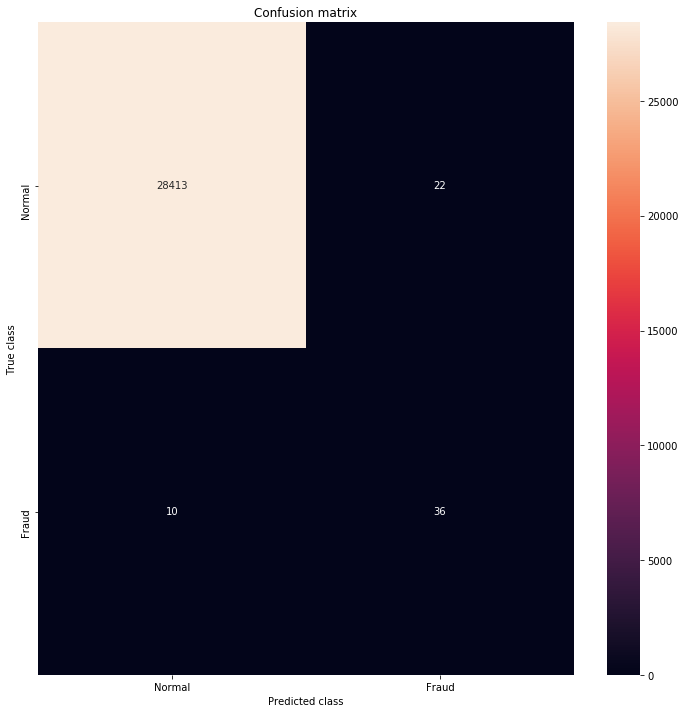

In [53]:
LABELS = ["Normal","Fraud"]
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
tn, fp, fn, tp = conf_matrix.ravel() 
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28435
           1       0.62      0.78      0.69        46

    accuracy                           1.00     28481
   macro avg       0.81      0.89      0.85     28481
weighted avg       1.00      1.00      1.00     28481



In [55]:
from sklearn.metrics import precision_score,accuracy_score, recall_score
accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
precision = precision_score(y_true=y_true, y_pred=y_pred)
recall = recall_score(y_true=y_true, y_pred=y_pred)

In [56]:
print ("")
print ("Accuracy Score: ", round(accuracy, 2))
print ("")
print ("Precision Score: ", round(precision, 2))
print ("")
print ("Recall Score: ", round(recall, 2))


Accuracy Score:  1.0

Precision Score:  0.62

Recall Score:  0.78


## Data Acknowledgements
The dataset used to demonstrated the fraud detection solution has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project We cite the following works:

- Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015
- Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon
- Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE
- Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)
- Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier
- Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing